In [1]:
import torch
import matplotlib.pyplot as plt
import plotly.express as px
import networkx as nx
import sys
import glob
import os
import numpy as np
import json
from tqdm import tqdm
sys.path.append("../")
from ml_graph_timer.dataset.layout_dataset import NpzDataset,GraphCollator

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torch.utils.data import DataLoader
from configs.listmle_gsage_bestparams import Configs

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [3]:
opcodes = json.load(open("/app/nn-runtime-network/assets/opt_code.json"))

In [4]:
CFG = Configs()

length of train: 529, length of valid: 24, length of test: 50


In [5]:
dataloader = DataLoader(CFG.valid_dataset, batch_size=1, shuffle=False, collate_fn=CFG.dataloder_collate_val,num_workers=0,pin_memory=False)
# zz = next(iter(dataloader))

In [6]:
CFG.load_state_dict(os.path.join(CFG.OUTPUTDIR,"latest_model.pkl"))
model = CFG.model
model.eval()
model.cuda()
1

loading model checkpoint from epoch:  2278


1

In [7]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

total, trainable = count_parameters(model)
print(f"Total parameters: {total}")
print(f"Trainable parameters: {trainable}")


Total parameters: 1262335
Trainable parameters: 1262335


In [8]:
outputs = []
# Function that will be called when the hook is triggered
def hook_fn(module, input, output):
    outputs.append(output.detach().cpu())

# Register the forward hook
hook = CFG.model.final_classifier.register_forward_hook(hook_fn)
nodeinfo = []
nodeops_indo = []
with torch.no_grad():
    for zz in tqdm(dataloader):
        if zz["node_features"].shape[0]/zz["batches"].shape[0]>10000:
            continue
        out = model(**{k:zz[k].cuda() for k in zz}).cpu()
        aggregated = [[] for _ in torch.unique(zz["node_separation"])]
        start_idx = 0
        for b,ns in enumerate(zz["node_separation"]):
            end_idx = ns
            aggregated[b].append(outputs[-1][start_idx:end_idx])
            start_idx = end_idx
        aggregated = torch.squeeze(torch.stack([torch.stack(x) for x in aggregated])).numpy()
        nodeinfo.append(aggregated)
        nodeops = zz["node_ops"][:aggregated.shape[1]]
        nodeops_indo.append(nodeops)
hook.remove()


100%|██████████| 24/24 [00:37<00:00,  1.55s/it]


In [11]:
node_opcodes = []
all_opcodes = []
for idx in tqdm(range(len(nodeinfo))):
    node_opcodes.extend(nodeops_indo[idx][nodeinfo[idx].std(0)>0.001].numpy())
    all_opcodes.extend(nodeops_indo[idx].numpy())

100%|██████████| 22/22 [00:00<00:00, 955.92it/s]


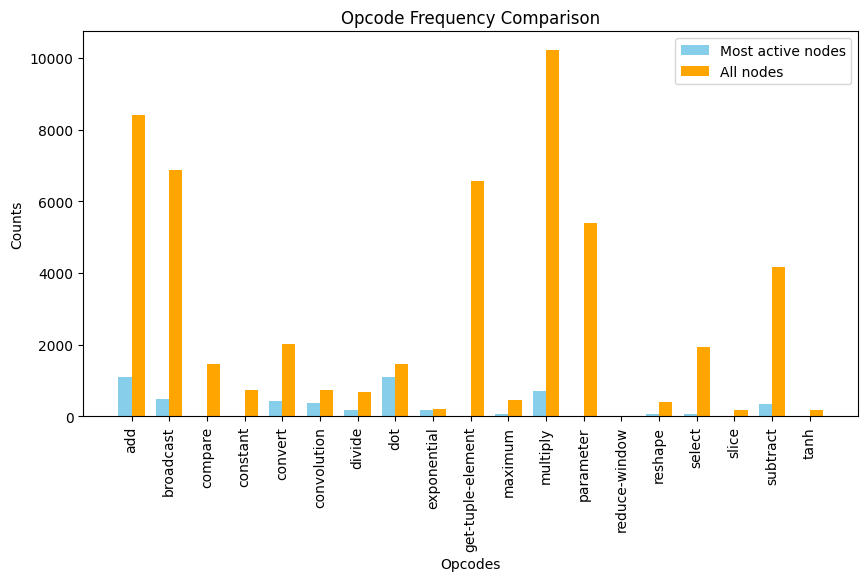

In [13]:
opcodes_name = list(opcodes.values())

# Calculate unique opcodes and their counts for active nodes
unique_opcodes_active, counts_active = np.unique(node_opcodes, return_counts=True)

# Calculate unique opcodes and their counts for all nodes
unique_opcodes, counts_all = np.unique([a for a in all_opcodes if a in unique_opcodes_active], return_counts=True)

# Ensure we have counts for all opcodes even if they don't appear in the node_opcodes
counts_all_aligned = np.zeros_like(counts_active)
for i, opcode in enumerate(unique_opcodes_active):
    if opcode in unique_opcodes:
        counts_all_aligned[i] = counts_all[np.where(unique_opcodes == opcode)]

# Plotting
plt.figure(figsize=(10, 5))

# Define the bar width
bar_width = 0.35

# Set the positions of the bars
indices = np.arange(len(unique_opcodes_active))
plt.bar(indices, counts_active, bar_width, label='Most active nodes', color='skyblue')
plt.bar(indices + bar_width, counts_all_aligned, bar_width, label='All nodes', color='orange')

# Adding labels and title
plt.xlabel('Opcodes')
plt.ylabel('Counts')
plt.title('Opcode Frequency Comparison')

# Adding the legend
plt.legend()

# Setting the xticks to be in the middle of the two bars
plt.xticks(indices + bar_width / 2, [opcodes_name[i] for i in unique_opcodes_active])

# Rotate the x-axis labels if needed
plt.xticks(rotation=90)

# Show the plot
plt.show()
